In [10]:
import math
from sklearn.metrics import r2_score
import numpy as np
import torch
import torch.nn as nn
from Rock.Model.MDN_by_Pytorch import mdn as mdn_advance, Mixture, NLLLoss
from Rock.Utils.View import init_weights
import matplotlib.pyplot as plt
import proplot as pplt
from sklearn.preprocessing import MinMaxScaler
import matplotlib
import joblib


In [2]:
input_parameters = [
    'Mass',
    'Radius',
    'Fe_(Mg+Si)',
    'k2',
]


output_parameters = [
    'WRF',
    'MRF',
    'CRF',
    'CMF',
    'PRS_CMB',
    'TEP_CMB',
]

In [3]:
test_x = np.load("D:\\Resource\\MDN\\TestDataMRCk2\\test_x.npy")
test_y = np.load("D:\\Resource\\MDN\\TestDataMRCk2\\test_y.npy")

In [4]:
model = mdn_advance(len(input_parameters), len(output_parameters), 10, 256)
init_weights(model)
model = nn.DataParallel(model)
model.to("cuda")
model.load_state_dict(torch.load("D:\\Resource\\MDN\\model_best_mdn_0.9951_-34_0.0002.pth"))

model.eval()
# Predict
pi, mu, sigma = model(torch.from_numpy(test_x))

In [5]:
mix = Mixture()
criterion = NLLLoss()
mse = nn.MSELoss()

In [6]:
sample = mix(pi, mu, sigma).sample()

In [11]:
print("NLLLoss: {}, MSE: {}, R2: {}".format(criterion(pi, mu, sigma, torch.from_numpy(test_y).to('cuda')), mse(torch.from_numpy(test_y).to('cuda'), sample), r2_score(sample.detach().cpu().numpy(), test_y)))

NLLLoss: -33.71051561750616, MSE: 0.0002195923864105937, R2: 0.9950418476930016


In [6]:
pi_exp = torch.exp(pi)
mu_np = mu.detach().cpu().numpy()
sigma_np = sigma.detach().cpu().numpy()
pi_np = pi_exp.detach().cpu().numpy()
s_y = joblib.load("D:\\Resource\\MDN\\TestDataMRCk2\\MDN_MRCk2_yscaler_20231201.save")
y_label = np.arange(0,1,0.01).reshape(-1,1)
y_label_ = y_label[:, np.newaxis, np.newaxis, :]


In [7]:
# Random choice number of data from test data
idx_select = np.random.choice(range(0, len(mu_np)), 20000)
mu_sub = mu_np[idx_select]
sigma_sub = sigma_np[idx_select]
pi_sub = pi_np[idx_select]

In [8]:
"""
    Calculate mixture probability density function
"""

mu_sub_T = np.transpose(mu_sub, (0, 2, 1))
sigma_sub_T = np.transpose(sigma_sub, (0, 2, 1))

# shape(1000, 6, 100, 10) 1000 data, 6 type, 100 rows with 10 columns every type
exponent = np.exp(-1/2*np.square(np.transpose((y_label_ - mu_sub_T), (1, 2, 0, 3))/sigma_sub_T[:, :, np.newaxis, :]))
factors = 1 / math.sqrt(2*math.pi) / sigma_sub_T[:, :, np.newaxis, :]
GMM_PDF = np.sum(pi_sub[:, np.newaxis, np.newaxis, :]*factors*exponent, axis=-1)
MM = MinMaxScaler()
GMM_PDF = GMM_PDF.reshape(GMM_PDF.shape[0] * GMM_PDF.shape[1], GMM_PDF.shape[-1]).transpose((-1, 0))
# f = e.transpose((-1, 0))
GMM_PDF_scaled = MM.fit_transform(GMM_PDF)

In [9]:
test_y_inverse = s_y.inverse_transform(test_y)
test_y_inverse_sub = test_y_inverse[idx_select]

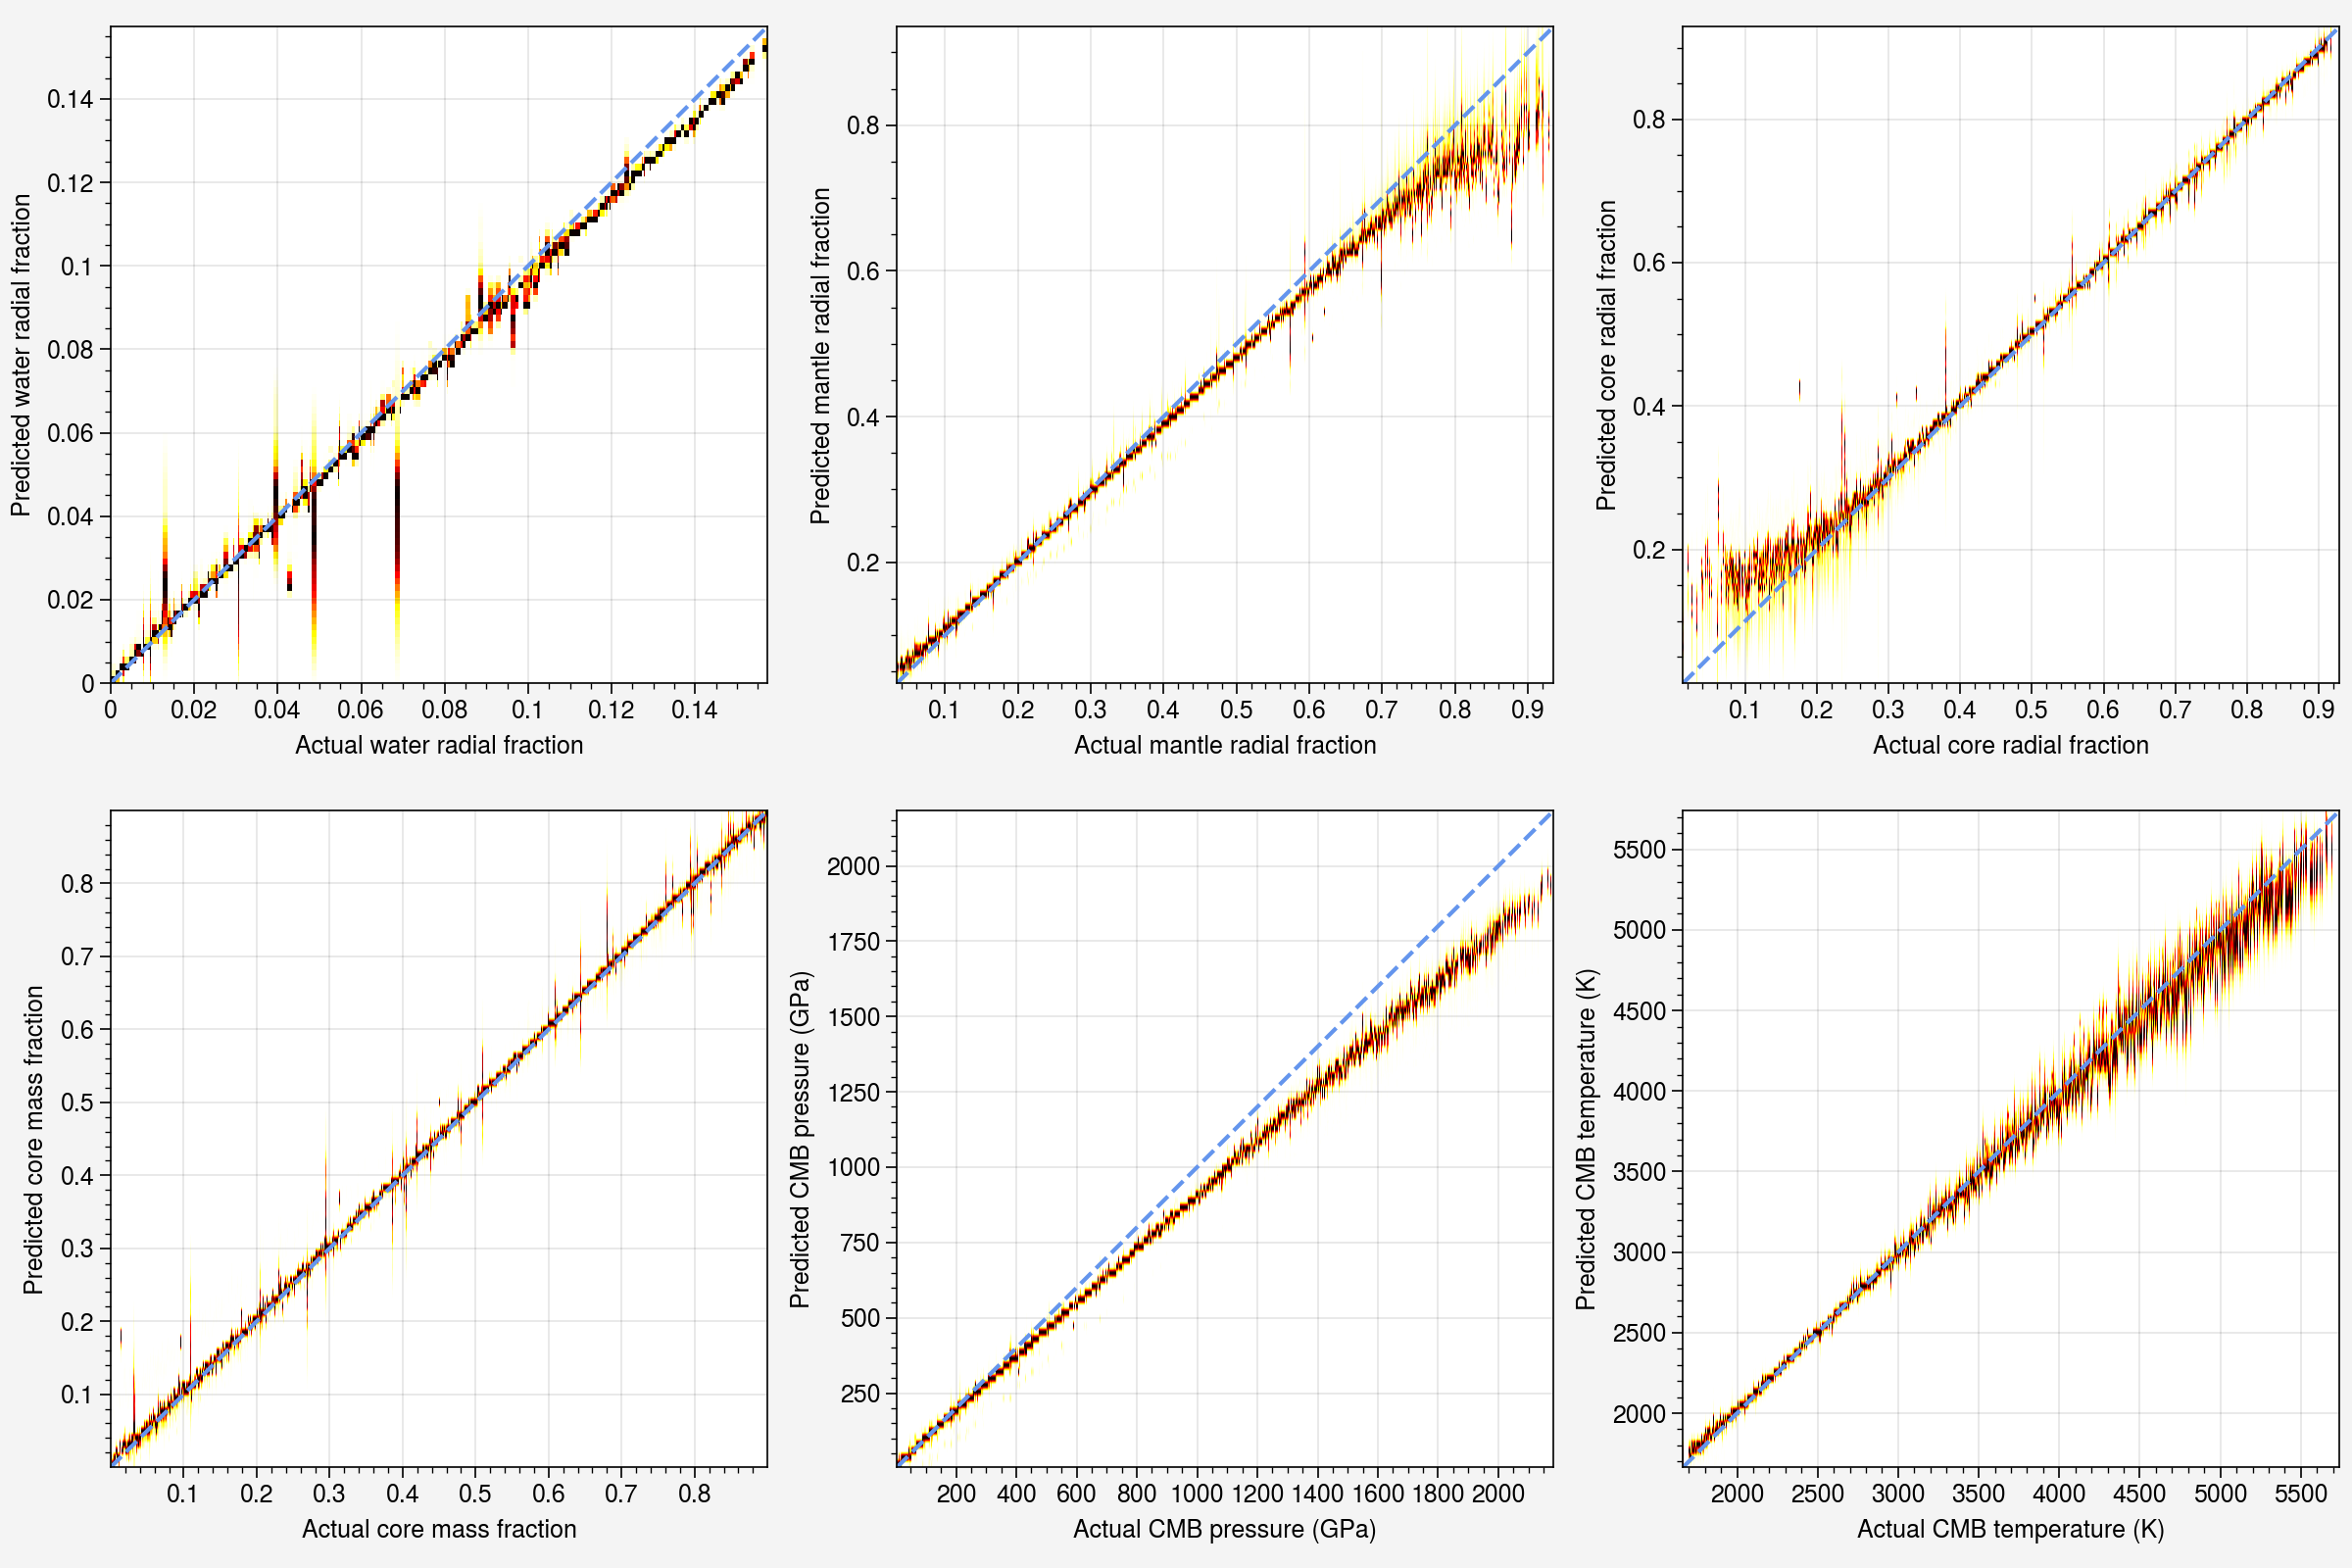

In [10]:
cmap = plt.cm.hot_r
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
fig, axs = pplt.subplots(
    nrows=2, ncols=3,
    share=False,
    figsize=(12, 8)
#     tight=True,
)
xlabels = [
    "Actual water radial fraction","Actual mantle radial fraction", "Actual core radial fraction",
    "Actual core mass fraction", "Actual CMB pressure (GPa)", "Actual CMB temperature (K)"
]
ylabels = [
    "Predicted water radial fraction","Predicted mantle radial fraction", "Predicted core radial fraction",
    "Predicted core mass fraction", "Predicted CMB pressure (GPa)", "Predicted CMB temperature (K)"
]

xlocators = [
    0.02, 0.1, 0.1, 0.1, 200, 500
]
xminorlocators = [
    0.005, 0.02, 0.02, 0.02, 50, 100
]
OUTPUT_DIMS = len(output_parameters)

for o in range(OUTPUT_DIMS):
    y_max = max(test_y_inverse_sub[:, o])
    y_min = min(test_y_inverse_sub[:, o])
    for i in range(0, GMM_PDF_scaled.shape[-1], 6):
        tx, ty = [test_y_inverse_sub[int(i / 6), o], y_min]
        axs[o].imshow(
                GMM_PDF_scaled[:, o + i].reshape(-1, 1),
                cmap=cmap,
                norm=norm,
                origin='lower',
                extent=(tx, tx + 0.001, ty, y_max)
            )

    axs[o].plot([y_min, y_max], [y_min, y_max], c='cornflowerblue', ls='--')
    axs[o].format(
        xlim=(y_min, y_max), ylim=(y_min, y_max),
        xlabel=xlabels[o], ylabel=ylabels[o],
        xlocator=xlocators[o], xminorlocator=xminorlocators[o]
    )

In [ ]:
fig.save('D:\\PythonProject\\RebuildProject\\Rock\\imgs\\prediction_MRCk2_20231201.png')